<!-- # データの前処理 -->

# 量質混合データ用
[Methods]
- Clustering methods : KPrototype, FSS-KPrototype
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

### 実験設定

In [1]:
clusters = 4  # クラスタ数
n_features_to_select = 7  # 選択される最大の特徴量数

N_SAMPLES = 100  # 標本サイズ
H = clusters
N_TRIALS = 1000  # 試行回数
N_EXPERIMENT = 10
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
CRITERION_LIST = ["none"]  # "ml", "tr"は後で入れる
CLUSTERING_METHOD_LIST = ["kprototype"]

------------------
### ライブラリのインポート & その他の設定

In [2]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# kmodes
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.style.use("ggplot")

Seed set to 8


------------
### データの前処理
外れ値除去 ⇒ 量的データのみ標準化

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### df1 : 健康栄養調査

In [4]:
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\NHANES_age_prediction.csv"
)
obj1 = "BMXBMI"
features_list1 = [
    "RIDAGEYR",  # 年齢（連続変数）
    "RIAGENDR",  # 性別（1:Male, 2:Female)
    "PAQ605",  # 運動有無(1:日常的に運動する, 2:運動しない)
    "LBXGLU",  # 断食後の血糖値（連続変数）
    "DIQ010",  # 糖尿病の有無(0:なし、1:あり)
    "LBXGLT",  # 口内の健康状態（連続変数）
    "LBXIN",  # 血中インスリン濃度（連続変数）
]

df1 = df1.drop(columns=["SEQN", "age_group"])
print("外れ値除外前", df1.shape)

df1 = remove_outliers_zscore(df1, obj1)
df1 = df1.reset_index(drop=True)
print("外れ値除外後", df1.shape)

# 量的データと質的データに分割する
numerical_features = ["RIDAGEYR", "LBXGLU", "LBXGLT", "LBXIN"]
catagorical_features = ["RIAGENDR", "PAQ605", "DIQ010"]
X_numerical = df1[numerical_features]
X_catagorical = df1[catagorical_features]

# 量的データは標準化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X_numerical)
X_numerical_scaled = pd.DataFrame(features_scaled, columns=numerical_features)

X = pd.concat([X_numerical_scaled, X_catagorical], axis=1)
y = df1[obj1]

df1 = pd.concat([X, y], axis=1)
print("量的データ標準化後", df1.shape)

X_scaled = df1[features_list1]
y = df1[obj1]
catColumnsPos = [X_scaled.columns.get_loc(col) for col in catagorical_features]

外れ値除外前 (2278, 8)
外れ値除外後 (2170, 8)
量的データ標準化後 (2170, 8)


----------------
### Wrapper 法でクラスタリング

##### Wrapper class

In [5]:
# class Wrapper(BaseEstimator, TransformerMixin):
#     def __init__(
#         self,
#         n_features_to_select: int,
#         n_clusters: int,
#         criterion: str = "ml",
#         clustering_method: str = "kprototype",
#         random_state: int = 0,
#     ):
#         self.n_features_to_select = n_features_to_select  # 特徴量数
#         self.n_clusters = n_clusters  # クラスタ数
#         self.criterion = criterion  # 特徴量選択基準
#         self.clustering_method = clustering_method  # クラスタリング手法
#         self.random_state = random_state

#     def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Wrapper":
#         X, y = check_X_y(X, y)

#         n_features = X.shape[1]  # 総特徴量数
#         self.selected_features_ = []  # ここに選択した特徴量を入れる

#         # 選ばれた特徴量と残っている特徴量の初期化
#         current_features = []
#         remaining_features = list(range(n_features))
#         best_score = -np.inf

#         while len(current_features) < self.n_features_to_select:
#             best_feature = None  # 選ぶ特徴量の初期化

#             for feature in remaining_features:
#                 temp_features = tuple(
#                     current_features + [feature]
#                 )  # 特徴量をひとつ加え、score計算
#                 score = self.crit(X[:, temp_features], temp_features)

#                 if score > best_score:
#                     best_score = score
#                     best_feature = feature

#             if best_feature is not None:
#                 current_features.append(
#                     best_feature
#                 )  # best feature をcurrent features に追加
#                 remaining_features.remove(
#                     best_feature
#                 )  # best feature をremaining features から取り除く
#                 self.selected_features_ = current_features
#             else:
#                 break

#         # 選ばれた特徴量サブセットでクラスタリング
#         final_features = X[:, self.selected_features_]
#         if self.clustering_method == "kprototype":
#             catColumnsPos_final = [
#                 i for i in self.selected_features_ if i in catColumnsPos
#             ]
#             if catColumnsPos_final == []:
#                 self.final_model_ = KMeans(
#                     n_clusters=self.n_clusters,
#                     random_state=self.random_state,
#                 )
#                 self.final_model_.fit(final_features)
#                 self.final_cluster_assignments_ = self.final_model_.predict(
#                     final_features
#                 )
#             if sorted(catColumnsPos_final) == sorted(self.selected_features_):
#                 self.final_model_ = KModes(
#                     n_jobs=-1,
#                     n_clusters=self.n_clusters,
#                     random_state=self.random_state,
#                     init="Huang",
#                 )
#                 self.final_model_.fit(final_features)
#                 self.final_cluster_assignments_ = self.final_model_.predict(
#                     final_features
#                 )
#             elif catColumnsPos_final != []:
#                 self.final_model_ = KPrototypes(
#                     n_jobs=-1,
#                     n_clusters=clusters,
#                     init="Huang",
#                     random_state=self.random_state,
#                 )
#                 self.final_model_.fit(final_features, categorical=catColumnsPos_final)
#                 self.final_cluster_assignments_ = self.final_model_.predict(
#                     final_features
#                 )
#         else:
#             raise ValueError(f"Unknown clustering method: {self.clustering_method}")

#         return self

#     def crit(self, X: pd.DataFrame, temp_features: list[int]) -> float:
#         if self.clustering_method == "kprototype":
#             temp_features_list = list(temp_features)
#             catColumnsPos_temp = [i for i in temp_features_list if i in catColumnsPos]
#             print(catColumnsPos_temp)

#             if catColumnsPos_temp == []:
#                 kmeans = KMeans(
#                     n_clusters=self.n_clusters,
#                     random_state=self.random_state,
#                 )
#                 kmeans.fit(X)
#                 labels = kmeans.predict(X)
#                 model = kmeans

#             if sorted(catColumnsPos_temp) == sorted(temp_features_list):
#                 kmodes = KModes(
#                     n_jobs=-1,
#                     n_clusters=self.n_clusters,
#                     random_state=self.random_state,
#                     init="Huang",
#                 )
#                 kmodes.fit(X)
#                 labels = kmodes.predict(X)
#                 model = kmodes

#             elif catColumnsPos_temp != []:
#                 kprototype = KPrototypes(
#                     n_jobs=-1,
#                     n_clusters=clusters,
#                     init="Huang",
#                     random_state=self.random_state,
#                 )
#                 kprototype.fit(X, categorical=catColumnsPos_temp)
#                 labels = kprototype.predict(X)
#                 model = kprototype

#             if self.criterion == "tr": #############ここをなおす
#                 labels = model.labels_
#                 cluster_centers = model.cluster_centers_

#                 sw_i_list = []
#                 for i in range(self.n_clusters):
#                     cluster_points = X[labels == i]

#                     if cluster_points.shape[0] <= 2:
#                         # データポイントが1つの場合はゼロ行列を使用
#                         sw_i = np.zeros((X.shape[1], X.shape[1])) + 1e-7
#                     else:
#                         sw_i = (np.cov(cluster_points, rowvar=False) + 1e-7) * np.sum(
#                             labels
#                             == i  # データ数を重みに使う代わりにデータの割合を使う
#                         )
#                         if np.isscalar(sw_i):  # スカラー値のとき
#                             sw_i = np.array([[sw_i]])
#                     sw_i_list.append(sw_i)

#                 # 全クラスターの S_W を合計
#                 S_W = np.sum(sw_i_list, axis=0)

#                 # クラスター間散布行列 S_B を計算
#                 overall_mean = np.mean(X, axis=0)
#                 S_B = sum(
#                     (np.sum(labels == i) / X.shape[0])  # 割合にする
#                     * np.outer(
#                         cluster_centers[i] - overall_mean,
#                         cluster_centers[i] - overall_mean,
#                     )
#                     # *(cluster_centers[i] - overall_mean) @ (cluster_centers[i] - overall_mean).T
#                     for i in range(self.n_clusters)
#                 )

#                 # 散乱分離性を計算
#                 score = np.trace(np.linalg.solve(S_W, S_B))

#             elif self.criterion == "ml":
#                 score = -model.score(X)

#         return score

#     def get_feature_index_out(self) -> NDArray:
#         return np.array(self.selected_features_)  # 選択された特徴量のインデックス

#     def get_final_cluster_assignments(self) -> NDArray:
#         return self.final_cluster_assignments_  # 最終的なクラスタリング結果

##### Wrapper class でクラスタリングしたとき

In [6]:
# # Wrapper法を実装するための関数
# def process_wrapper(
#     name: str, instance: "Wrapper", X_scaled: pd.DataFrame, y: pd.DataFrame
# ):
#     instance.fss(X_scaled, y)
#     selected_features_index = instance.get_feature_index_out()
#     cluster_label = instance.get_final_cluster_assignments()
#     cluster_size = np.unique(cluster_label, return_counts=True)[1]

#     return selected_features_index, cluster_label, cluster_size


# # Wrapperインスタンスのリスト
# instances = [
#     (
#         "fsskprototype_tr",
#         Wrapper(
#             n_features_to_select=n_features_to_select,
#             n_clusters=clusters,
#             criterion="tr",
#             clustering_method="kprototype",
#             random_state=0,
#         ),
#     ),
#     (
#         "fsskprototype_ml",
#         Wrapper(
#             n_features_to_select=n_features_to_select,
#             n_clusters=clusters,
#             criterion="ml",
#             clustering_method="kprototype",
#             random_state=0,
#         ),
#     ),
# ]

# # 辞書の初期化
# selected_features_index_dict = {}
# cluster_label_dict = {}
# cluster_size_dict = {}

# # 各インスタンスに対して処理を実行
# for name, instance in instances:
#     selected_features_index, cluster_label, cluster_size = process_wrapper(
#         name, instance, X_scaled, y
#     )
#     selected_features_index_dict[name] = selected_features_index
#     cluster_label_dict[name] = cluster_label
#     cluster_size_dict[name] = cluster_size
#     print("[", name, "]")
#     print("選択された特徴量のインデックス : ", selected_features_index)
#     print("選択された特徴量の数 : ", len(selected_features_index))
#     print("各層のクラスタサイズ : ", cluster_size)
#     print()

##### KPrototypesでクラスタリングしたとき

In [7]:
cluster_label_dict = {}
cluster_size_dict = {}

kprototype = KPrototypes(n_jobs=-1, n_clusters=clusters, init="Huang", random_state=0)
kprototype_cluster = kprototype.fit_predict(X_scaled, categorical=catColumnsPos)

kprototype_size = np.bincount(kprototype_cluster, minlength=clusters)

cluster_label_dict["kprototype"] = kprototype_cluster
cluster_size_dict["kprototype"] = kprototype_size

methods = ["kprototype"]
for name in methods:
    print("[", name, "]")
    print("各層のクラスタサイズ : ", cluster_size_dict[name])
    print()

[ kprototype ]
各層のクラスタサイズ :  [ 197   18 1101  854]



----------------------
### 標本配分

##### 基底クラス

In [8]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        n_samples: int,
        H: int,
        random_state: int,
        criterion: str,
        clustering_method: str,
    ):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state
        self.criterion = criterion
        self.clustering_method = clustering_method

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        if self.criterion == "tr" and self.clustering_method == "kprototype":
            cluster_label = cluster_label_dict["fsskprototype_tr"]
            cluster_size = cluster_size_dict["fsskprototype_tr"]
        if self.criterion == "ml" and self.clustering_method == "kprototype":
            cluster_label = cluster_label_dict["fsskprototype_ml"]
            cluster_size = cluster_size_dict["fsskprototype_ml"]
        if self.criterion == "none" and self.clustering_method == "kprototype":
            cluster_label = cluster_label_dict["kprototype"]
            cluster_size = cluster_size_dict["kprototype"]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size

##### 単純無作為抽出のクラス

In [9]:
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size

##### 比例配分のクラス

In [10]:
class ProportionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.n_samples).astype(int)

        if n.sum() > self.n_samples:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.n_samples

        if n.sum() < self.n_samples:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.n_samples

        # for i in range(
        #     len(n)
        # ):  # nの要素でm_VALUEより小さいものがあれば要素数が最も大きい層から持ってくる
        #     if n[i] < m_VALUE:
        #         delta = m_VALUE - n[i]
        #         n[i] = m_VALUE
        #         n[np.argmax(n)] -= delta

        return n

##### 事後層化のクラス

In [11]:
class PostStratification(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

##### 最適標本配分のクラス

In [12]:
class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        criterion: str = "none",
        clustering_method: str = "kprototype",
    ):
        super().__init__(
            n_samples, H, random_state, criterion, clustering_method
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.n_samples
        ), f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

##### 母平均の推定値を計算する関数

In [13]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        y_cluster = y[cluster_label == h]
        # クラスタ内でランダム n_h サンプリング
        sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new = np.unique(n_label)
    # n_new = np.unique(n_label, return_counts=True)[1]
    # for h in range(n_new.shape[0]):
    for h in n_new:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

##### 各ポリシーの生成

In [14]:
# 各ポリシーの生成を行う関数
def create_policies(
    criterion_list: list[str],
    clustering_method_list: list[str],
    n_samples: int,
    H: int,
    random_state: int,
    m_value: int,
) -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    for criterion in criterion_list:
        for clustering_method in clustering_method_list:
            policies: list[BaseAllocation] = [
                RandomAllocation(
                    n_samples=n_samples,
                    H=H,
                    random_state=random_state,
                    criterion=criterion,
                    clustering_method=clustering_method,
                ),
                ProportionalAllocation(
                    n_samples=n_samples,
                    H=H,
                    random_state=random_state,
                    criterion=criterion,
                    clustering_method=clustering_method,
                ),
                PostStratification(
                    n_samples=n_samples,
                    H=H,
                    random_state=random_state,
                    criterion=criterion,
                    clustering_method=clustering_method,
                ),
                OptimalAllocation(
                    n_samples=n_samples,
                    H=H,
                    random_state=random_state,
                    m=np.full(H, m_value),
                    M=None,
                    criterion=criterion,
                    clustering_method=clustering_method,
                ),
            ]
            policies_dict[(criterion, clustering_method)] = policies
    return policies_dict

-------------
### 母平均の推定と分散の計算

##### 母平均の推定

##### 結果の出力

In [15]:
policies_dict = create_policies(
    CRITERION_LIST, CLUSTERING_METHOD_LIST, N_SAMPLES, H, RANDOM_STATE, m_VALUE
)


def cauculate_reduction_rate(
    X: pd.DataFrame, y: pd.DataFrame, policies_dict: dict
) -> dict:
    reduction_rate_dict = {}
    allocations_dict = {}
    for method, policies in policies_dict.items():
        # それぞれの戦略で各クラスタの標本数を求解
        allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
        for policy in policies:
            # policyを用いてXをクラスタリング
            cluster_label, _ = policy.clustering(X_scaled)
            n = policy.solve(X_scaled, y)
            allocations.append(
                {
                    "policy": policy.__class__.__name__,
                    "n": n,
                    "cluster_label": cluster_label,
                }
            )
        allocations_dict[method] = allocations

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for method, allocations in allocations_dict.items():
        y_hats = []
        for random_state in range(N_TRIALS):
            for allocation in allocations:
                if allocation["policy"] == "PostStratification":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": random_state,
                    }
                )
        y_hats_dict[method] = y_hats

    method_list = []
    for method, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        # random_allocationの誤差分散
        random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"][
            "error"
        ].var()
        # random_allocation以外の誤差分散
        non_random_allocation_std = (
            y_hat_df[y_hat_df["policy"] != "RandomAllocation"]
            .groupby("policy")["error"]
            .var()
        )

        # 削減率
        reduction_rate = (1 - non_random_allocation_std / random_allocation_std) * 100

        ## policyの順番をpoliciesの順番に調整
        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        reduction_rate_dict[method] = reduction_rate
        method_list.append(method)

    return (
        reduction_rate_dict,
        method_list,
        random_allocation_std,
        non_random_allocation_std,
    )

In [16]:
_, methods, _, _ = cauculate_reduction_rate(X_scaled, y, policies_dict)

all_results = []

random_std_list = []
proportional_std_list = []
post_std_list = []
optimal_std_list = []

for i in range(N_EXPERIMENT):
    dict, _, random_std, non_random_std = cauculate_reduction_rate(
        X_scaled, y, policies_dict
    )
    all_results.append(dict)

    random_std_list.append(random_std)
    proportional_std_list.append(non_random_std["ProportionalAllocation"])
    post_std_list.append(non_random_std["PostStratification"])
    optimal_std_list.append(non_random_std["OptimalAllocation"])


results = {}
for method in methods:
    results[method] = {
        "RandomAllocation": [],
        "ProportionalAllocation": [],
        "PostStratification": [],
        "OptimalAllocation": [],
    }
for dict in all_results:
    for method, policy in dict.items():
        for allocation_method in list(policy.index):
            results[method][allocation_method].append(policy[allocation_method])


final_results = {}
for method in methods:
    final_results[method] = {
        "RandomAllocation": [],
        "ProportionalAllocation": [],
        "PostStratification": [],
        "OptimalAllocation": [],
    }
for method, dict in results.items():
    for allocation_method in list(dict.keys()):
        final_results[method][allocation_method] = np.mean(
            np.array(dict[allocation_method])
        )


for method, dict in final_results.items():
    print("criterion:", method[0], "clustering_method:", method[1])
    print(dict)
for method, dict in results.items():
    print("criterion:", method[0], "clustering_method:", method[1])
    print(dict)

std_dict = {}
std_dict["random"] = random_std_list
std_dict["proportional"] = proportional_std_list
std_dict["post"] = post_std_list
std_dict["optimal"] = optimal_std_list

criterion: none clustering_method: kprototype
{'RandomAllocation': nan, 'ProportionalAllocation': 18.91183714881704, 'PostStratification': 10.494204920262476, 'OptimalAllocation': 18.253552969897168}
criterion: none clustering_method: kprototype
{'RandomAllocation': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'ProportionalAllocation': [23.35190771734875, 13.10778819268721, 17.85524490119329, 28.297783242222042, 24.501650297985698, 14.570483111822485, 20.28422381905418, 14.428868495468949, 12.507135417312687, 20.21328629307506], 'PostStratification': [11.251800013276714, 5.999859919485074, 12.040253151400371, 18.0009138271935, 5.619739896385212, 16.363122524509155, 5.585943175640528, 11.38815204150715, 10.141827201606347, 8.550437451620708], 'OptimalAllocation': [23.26463616131492, 18.8454777405649, 21.91597884090779, 24.233352043013568, 20.354928937723226, 8.67223265157121, 11.788540859555397, 22.544288232827515, 13.825168569634705, 17.090925661858456]}


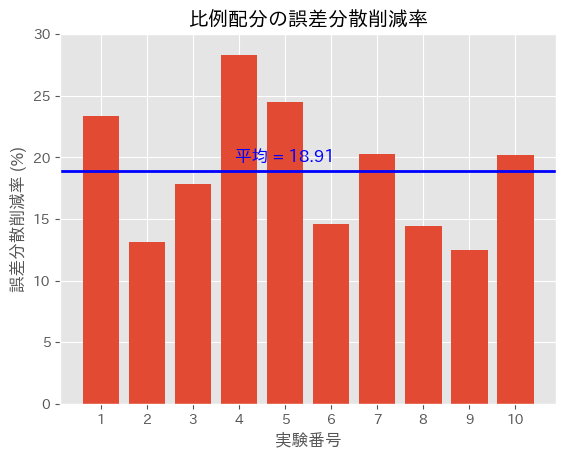

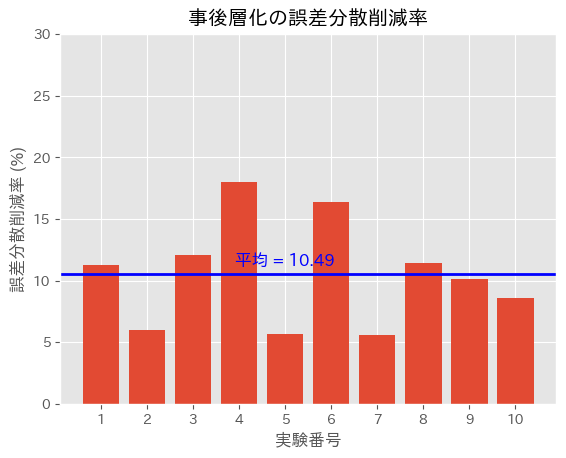

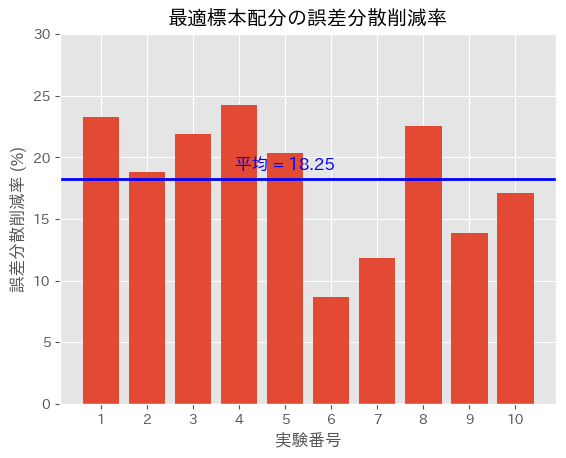

In [19]:
# 最初のキー以外の棒グラフを作成
data_reduction = results[("none", "kprototype")]
keys = list(data_reduction.keys())[1:]  # 最初のキー以外を選択
title_list1 = [
    "比例配分の誤差分散削減率",
    "事後層化の誤差分散削減率",
    "最適標本配分の誤差分散削減率",
]
num = -1

# 各キーに対して棒グラフを描画
for key in keys:
    num += 1
    mean = round(final_results[("none", "kprototype")][key], 2)
    values = data_reduction[key]
    x = range(1, len(values) + 1)  # 横軸のラベル
    plt.figure()  # 新しい図を作成
    plt.bar(x, values)
    plt.xlabel("実験番号")
    plt.ylabel("誤差分散削減率 (%)")
    plt.title(title_list1[num])  # キーをタイトルに設定
    plt.xticks(x)  # 横軸のラベルを1, 2, ..., Nに設定
    plt.axhline(
        y=mean,
        color="blue",
        linestyle="-",
        linewidth=2,
    )
    plt.text(
        len(values) / 2,
        mean + 0.5,
        f"平均 = {mean}",
        color="blue",
        fontsize=12,
        horizontalalignment="center",
        verticalalignment="bottom",
    )
    plt.ylim(0, 30)
    plt.show()

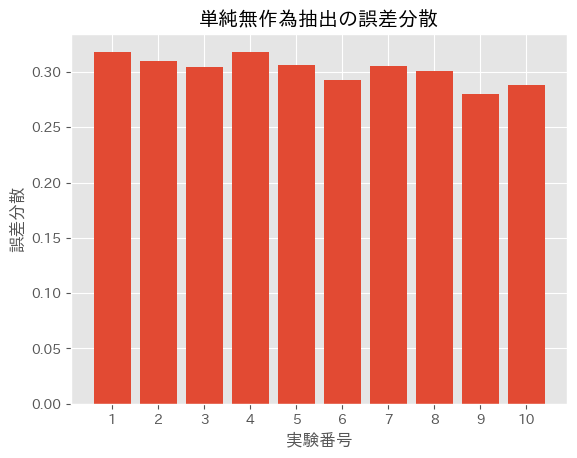

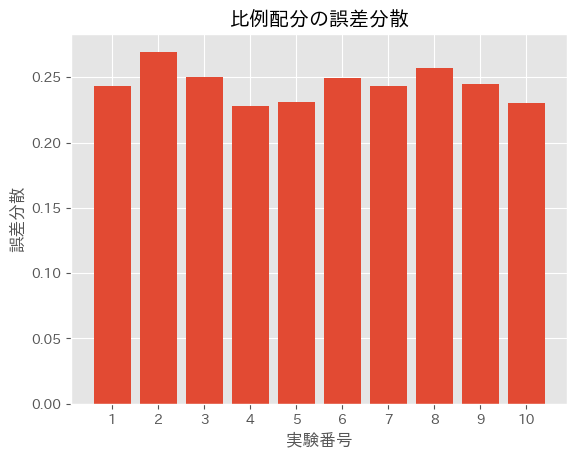

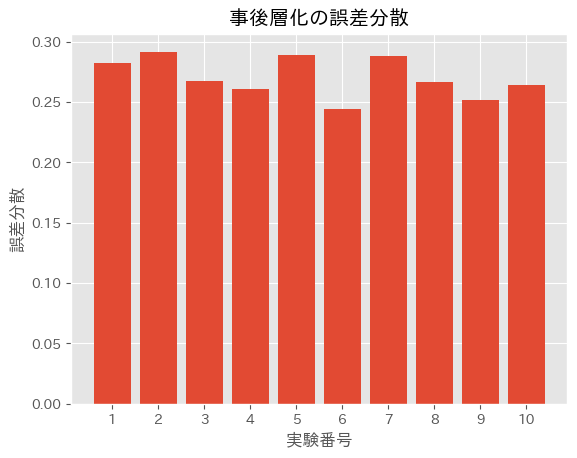

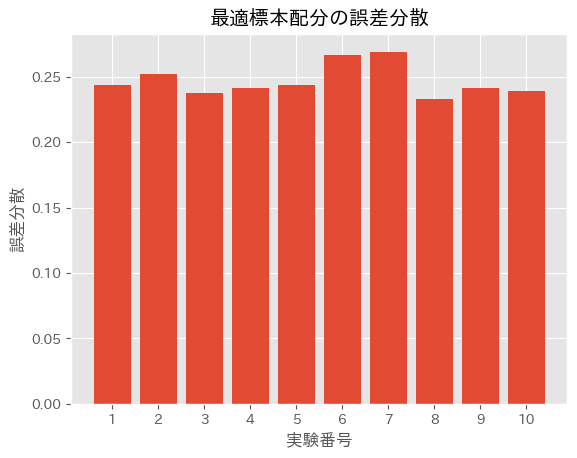

In [18]:
# 最初のキー以外の棒グラフを作成
data_std = std_dict
keys = list(data_std.keys())[:]  # 最初のキー以外を選択
title_list2 = [
    "単純無作為抽出の誤差分散",
    "比例配分の誤差分散",
    "事後層化の誤差分散",
    "最適標本配分の誤差分散",
]
num = -1

# 各キーに対して棒グラフを描画
for key in keys:
    num += 1
    values = data_std[key]
    x = range(1, len(values) + 1)  # 横軸のラベル
    plt.figure()  # 新しい図を作成
    plt.bar(x, values)
    plt.xlabel("実験番号")
    plt.ylabel("誤差分散")
    plt.title(title_list2[num])  # キーをタイトルに設定
    plt.xticks(x)  # 横軸のラベルを1, 2, ..., Nに設定
    plt.show()